# Predicting Hotel Cancellations

## 🏨 Background

You are supporting a hotel with a project aimed to increase revenue from their room bookings. They believe that they can use data science to help them reduce the number of cancellations. This is where you come in! 

They have asked you to use any appropriate methodology to identify what contributes to whether a booking will be fulfilled or cancelled. They intend to use the results of your work to reduce the chance someone cancels their booking.

## The Data

They have provided you with their bookings data in a file called `hotel_bookings.csv`, which contains the following:

| Column     | Description              |
|------------|--------------------------|
| `Booking_ID` | Unique identifier of the booking. |
| `no_of_adults` | The number of adults. |
| `no_of_children` | The number of children. |
| `no_of_weekend_nights` | Number of weekend nights (Saturday or Sunday). |
| `no_of_week_nights` | Number of week nights (Monday to Friday). |
| `type_of_meal_plan` | Type of meal plan included in the booking. |
| `required_car_parking_space` | Whether a car parking space is required. |
| `room_type_reserved` | The type of room reserved. |
| `lead_time` | Number of days before the arrival date the booking was made. |
| `arrival_year` | Year of arrival. |
| `arrival_month` | Month of arrival. |
| `arrival_date` | Date of the month for arrival. |
| `market_segment_type` | How the booking was made. |
| `repeated_guest` | Whether the guest has previously stayed at the hotel. |
| `no_of_previous_cancellations` | Number of previous cancellations. |
| `no_of_previous_bookings_not_canceled` | Number of previous bookings that were canceled. |
| `avg_price_per_room` | Average price per day of the booking. |
| `no_of_special_requests` | Count of special requests made as part of the booking. |
| `booking_status` | Whether the booking was cancelled or not. |

Source (data has been modified): https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

## The Challenge

* Use your skills to produce recommendations for the hotel on what factors affect whether customers cancel their booking.

# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('whitegrid')

import missingno as msno
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
hotels = pd.read_csv("data/hotel_bookings.csv")
print(hotels.shape)
hotels.head()

(36275, 19)


,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not_Canceled
1,INN00002,2.0,0.0,2.0,3.0,Not Selected,0.0,Room_Type 1,5.0,2018.0,11.0,6.0,Online,0.0,0.0,0.0,106.68,1.0,Not_Canceled
2,INN00003,1.0,0.0,2.0,1.0,Meal Plan 1,0.0,Room_Type 1,1.0,2018.0,2.0,28.0,Online,0.0,0.0,0.0,60.00,0.0,Canceled
3,INN00004,2.0,0.0,0.0,2.0,Meal Plan 1,0.0,Room_Type 1,211.0,2018.0,5.0,20.0,Online,0.0,0.0,0.0,100.00,0.0,Canceled
4,INN00005,2.0,0.0,1.0,1.0,Not Selected,0.0,Room_Type 1,48.0,2018.0,4.0,11.0,Online,0.0,0.0,0.0,94.50,0.0,Canceled


In [3]:
hotels.dtypes

Booking_ID                               object
no_of_adults                            float64
no_of_children                          float64
no_of_weekend_nights                    float64
no_of_week_nights                       float64
type_of_meal_plan                        object
required_car_parking_space              float64
room_type_reserved                       object
lead_time                               float64
arrival_year                            float64
arrival_month                           float64
arrival_date                            float64
market_segment_type                      object
repeated_guest                          float64
no_of_previous_cancellations            float64
no_of_previous_bookings_not_canceled    float64
avg_price_per_room                      float64
no_of_special_requests                  float64
booking_status                           object
dtype: object

# Preprocessing

In [4]:
df = hotels.copy()

# drop unique identifier column
df = df.drop('Booking_ID', axis = 1)

## Null values

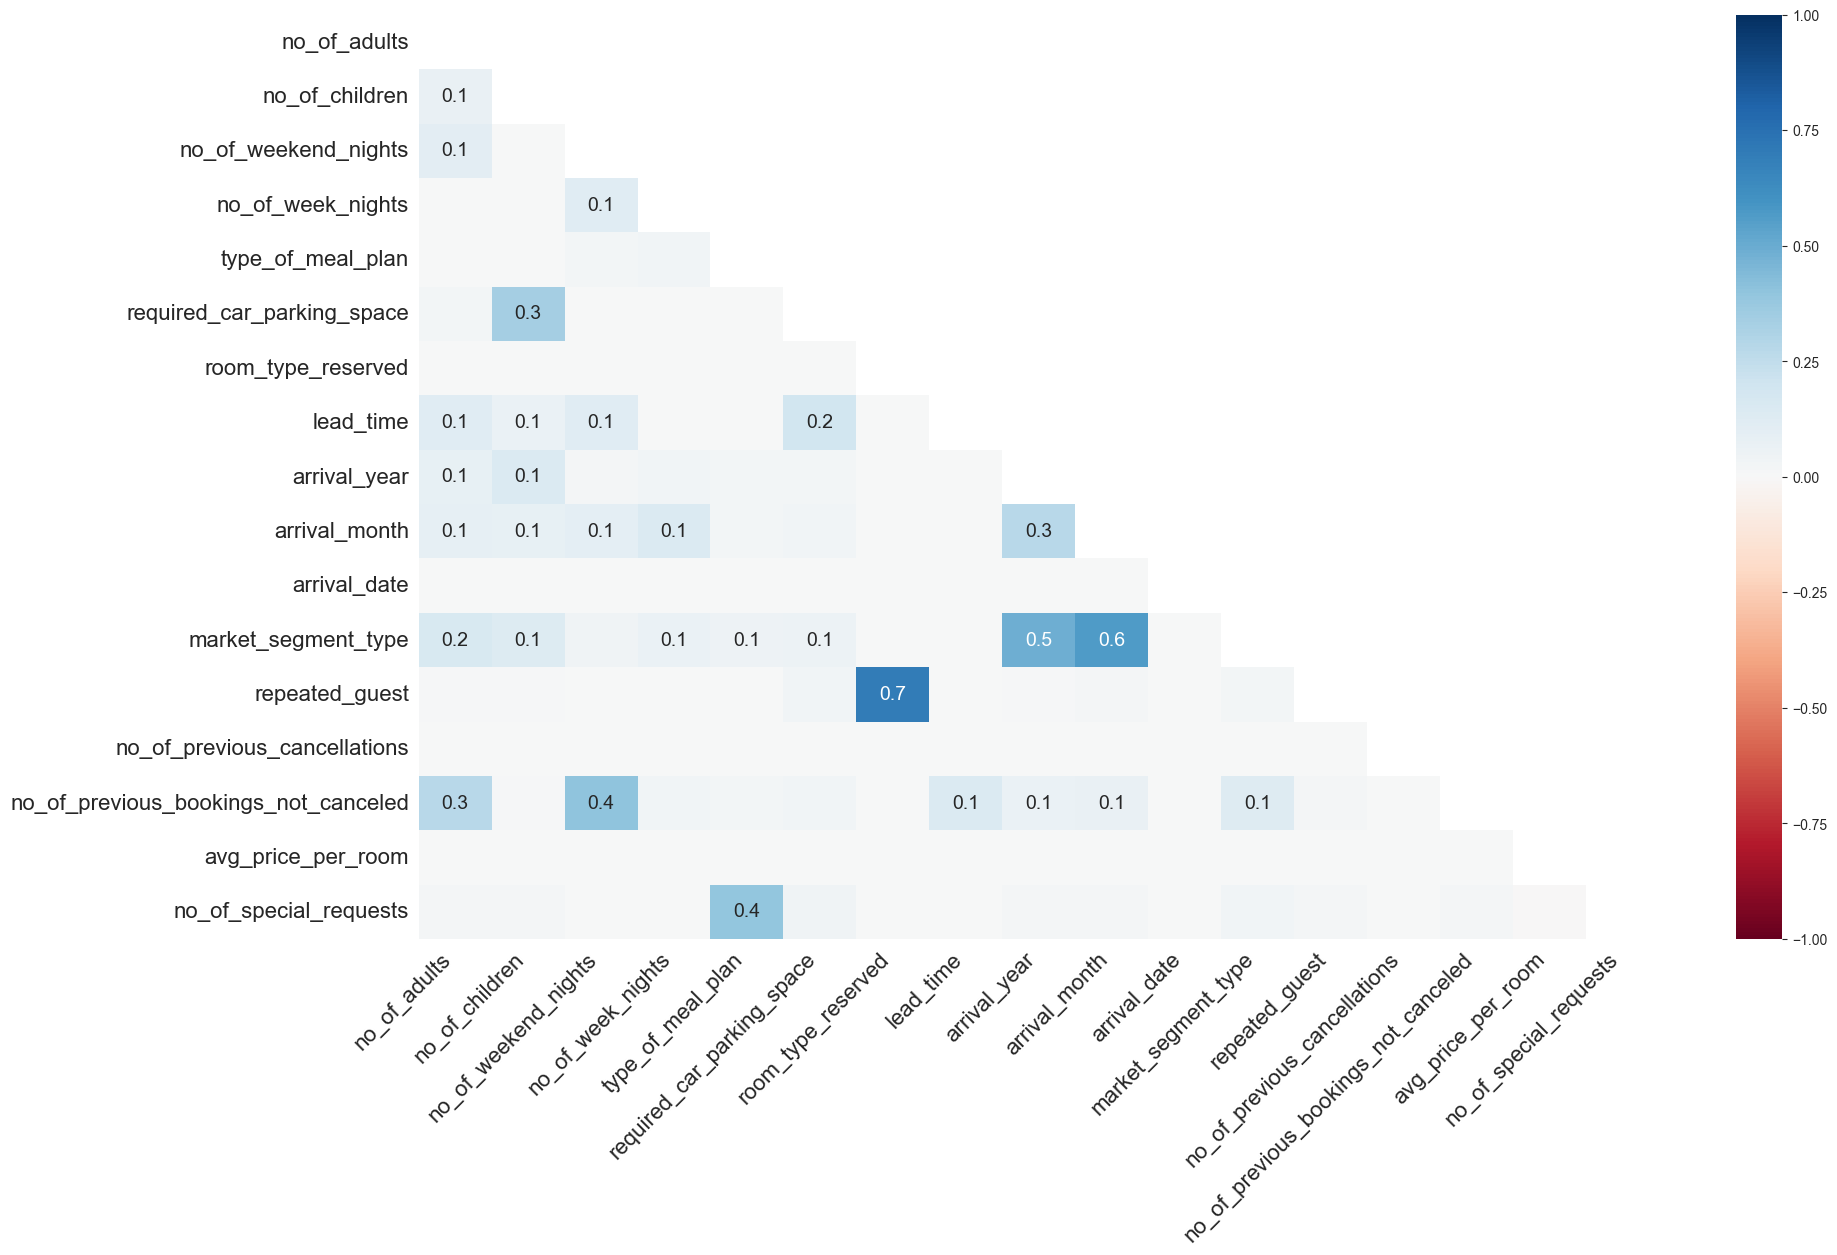

In [5]:
msno.heatmap(df);

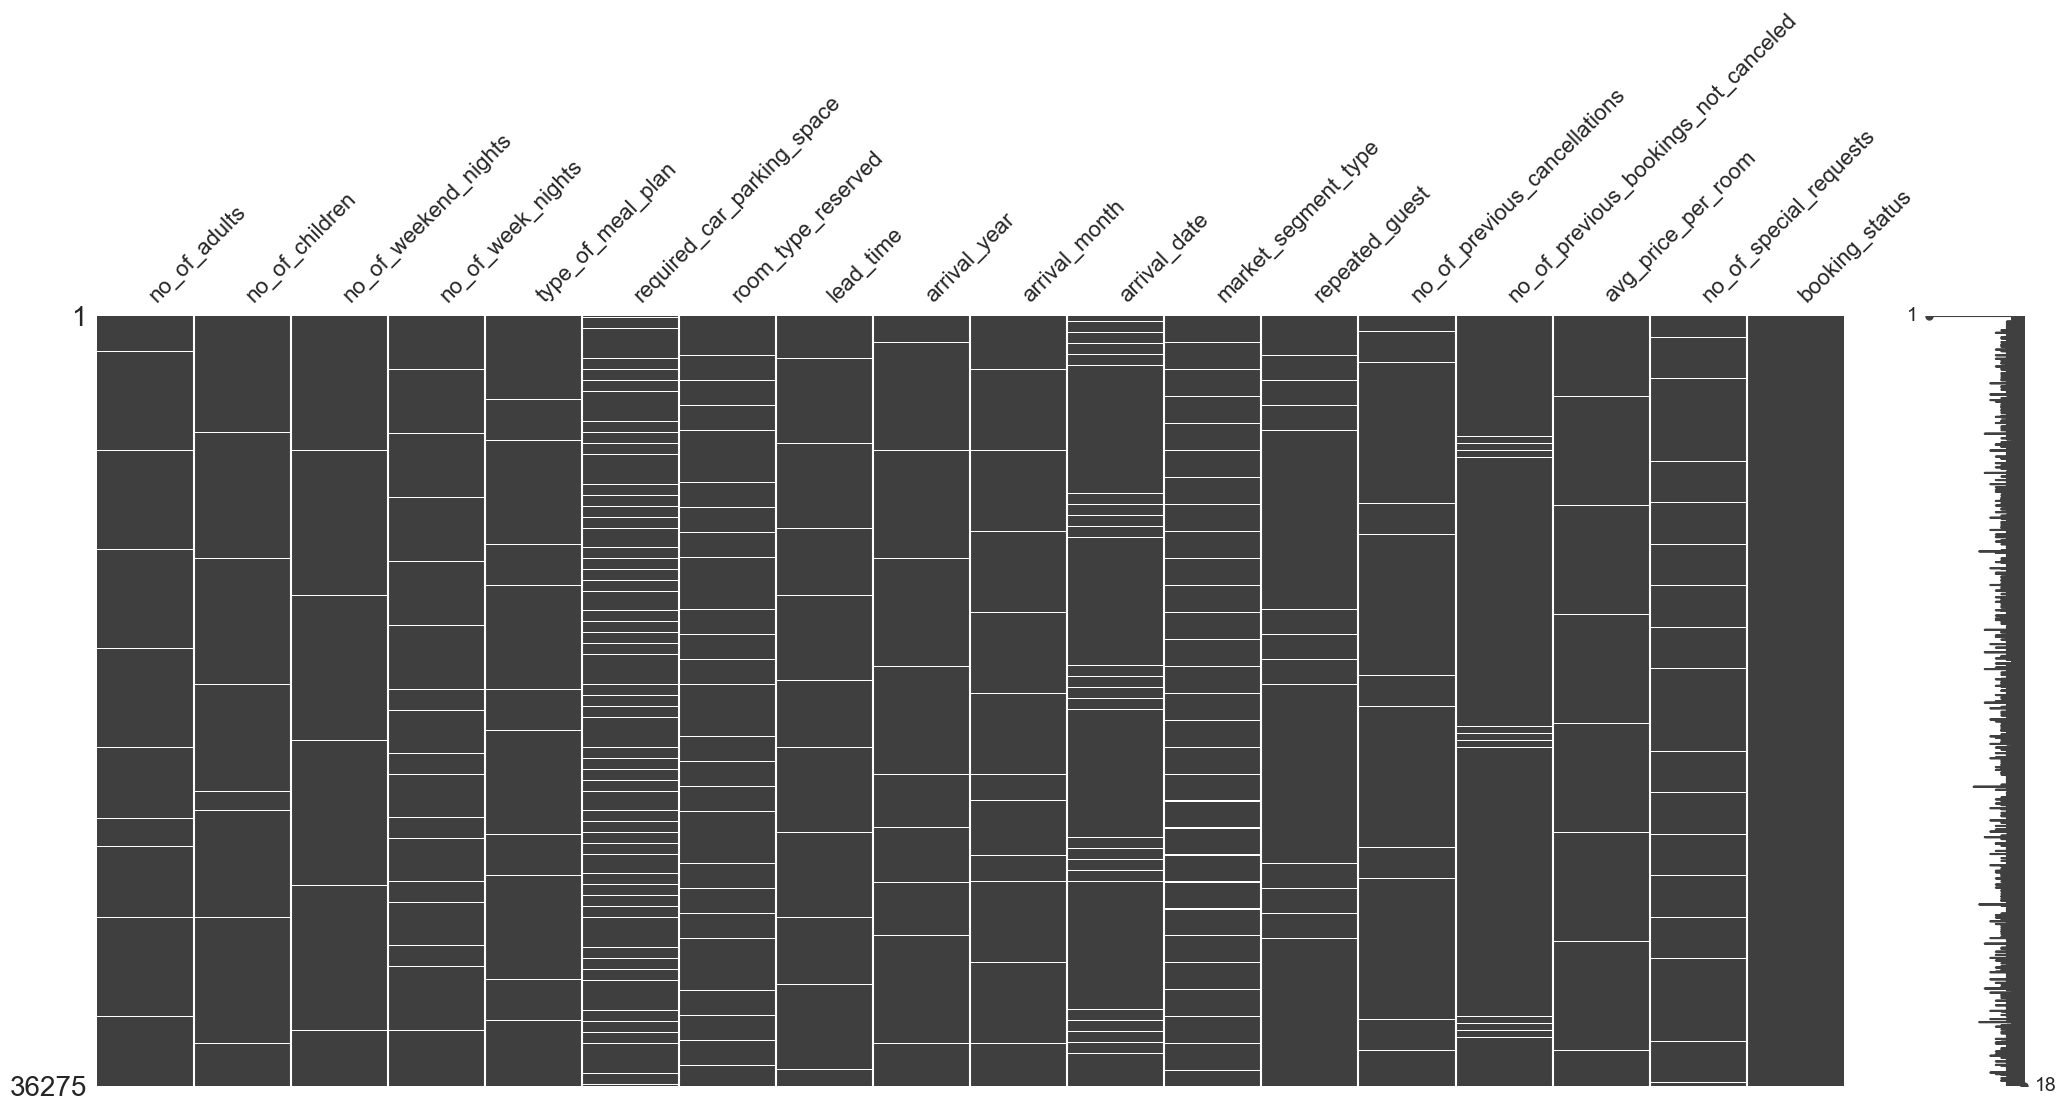

In [6]:
msno.matrix(df);

In [7]:
nulldf = df.isnull().sum().sort_values(ascending = False).reset_index()
nulldf.columns = ['feature', 'null_count']
nulldf = nulldf[nulldf['null_count'] > 0]

In [8]:
remove = df[nulldf['feature'].values].sum(axis = 1).sort_values().reset_index()
remove.columns = ['index', 'value']
remove = remove[remove['value'] == 0]
remove_indices = remove['index'].values

/var/folders/qq/_pxy1w012md00pykw2bn68bw0000gn/T/ipykernel_79043/2069054682.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  remove = df[nulldf['feature'].values].sum(axis = 1).sort_values().reset_index()


In [9]:
df = df[~df.index.isin(remove_indices)]

## Create Date Column

In [10]:
df['arrival_year'] = df['arrival_year'].fillna(1900).astype(int)
df['arrival_month'] = df['arrival_month'].fillna(1).astype(int)
df['arrival_date'] = df['arrival_date'].fillna(1).astype(int)

df['date_str'] = df.apply(lambda x: f"{int(x['arrival_year'])}-{int(x['arrival_month'])}-{int(x['arrival_date'])}", axis = 1)
fmt = "%Y-%m-%d"

# reclassify dates
df.loc[df['date_str'] == '2018-2-29', 'date_str'] = '2018-2-28'
df.loc[df['date_str'] == '1900-2-29', 'date_str'] = '1900-2-28'

# create date column
data  = []
for i, row in df.iterrows():
    try:
        data.append(datetime.strptime(row['date_str'], fmt))
    except:
        print(row['date_str'])
df['date'] = data

# drop date_str
df = df.drop('date_str', axis = 1)

# EDA

In [11]:
target = 'booking_status'

## Time Series Analysis

### Historic performance: Aggregate

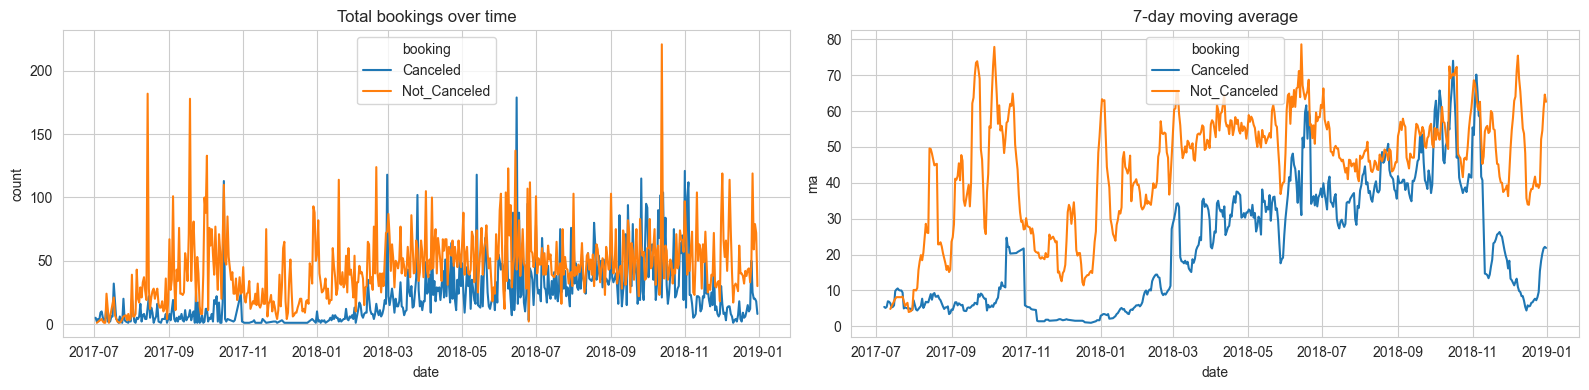

In [12]:
moving_avg_val = 7
start_year = '2017-07-01'

tmp = df[df['date'] > start_year]

fig, axs = plt.subplots(1, 2, figsize = (16, 4))

tmp = tmp.groupby(['date',target]).size().reset_index()
tmp.columns = ['date', 'booking', 'count']

tmp['ma'] = tmp.groupby('booking')['count'].transform(lambda x: x.rolling(window = moving_avg_val, min_periods = 7).mean())

sns.lineplot(data = tmp, x = 'date', y = 'count', hue = 'booking', ax = axs[0])
sns.lineplot(data = tmp, x = 'date', y = 'ma', hue = 'booking', ax = axs[1])
axs[0].set_title("Total bookings over time")
axs[1].set_title(f"{moving_avg_val}-day moving average")
plt.tight_layout()

### Historic Performance: Percentage

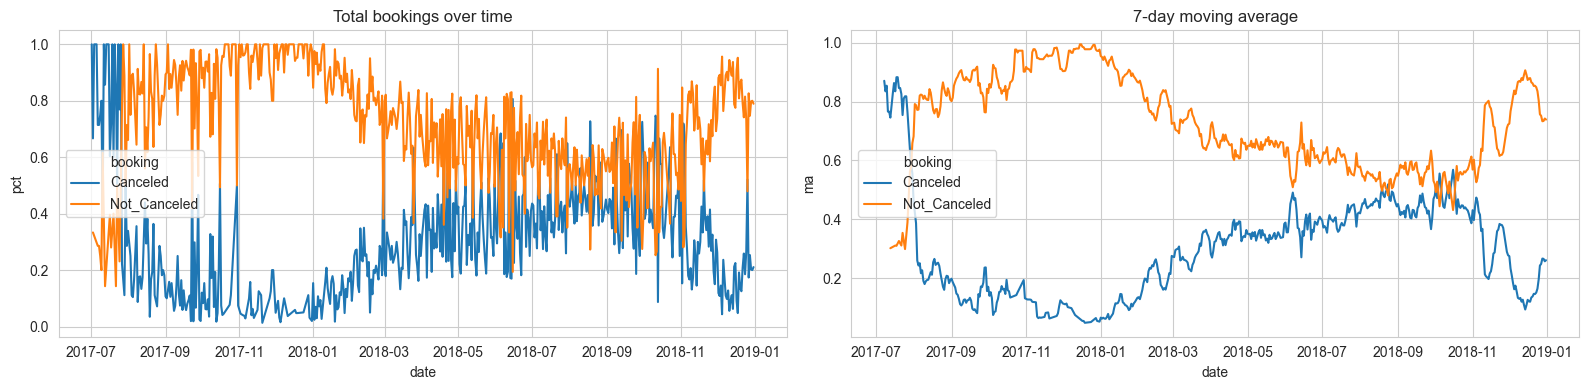

In [13]:
tmp = df[df['date'] > start_year]

fig, axs = plt.subplots(1, 2, figsize = (16, 4))

tmp = tmp.groupby(['date',target]).size().reset_index()
tmp.columns = ['date', 'booking', 'count']
total_mapping = tmp.groupby('date')['count'].sum().to_dict()
tmp['total'] = tmp['date'].map(total_mapping)
tmp['pct'] = tmp['count'] / tmp['total']

tmp['ma'] = tmp.groupby('booking')['pct'].transform(lambda x: x.rolling(window = moving_avg_val, min_periods = 7).mean())

sns.lineplot(data = tmp, x = 'date', y = 'pct', hue = 'booking', ax = axs[0])
sns.lineplot(data = tmp, x = 'date', y = 'ma', hue = 'booking', ax = axs[1])
axs[0].set_title("Total bookings over time")
axs[1].set_title(f"{moving_avg_val}-day moving average")
plt.tight_layout()

In [14]:
match = tmp.groupby('booking')['ma'].max().reset_index()
pd.merge(match, tmp, on = ['booking','ma'])

,booking,ma,date,count,total,pct
0,Canceled,0.882988,2017-07-18,18,25,0.72
1,Canceled,0.882988,2017-07-19,4,4,1.00
2,Not_Canceled,0.994709,2017-12-15,9,9,1.00
3,Not_Canceled,0.994709,2017-12-16,13,13,1.00


In [15]:
# Flagged period discovered when cancellations were anomalous

flagged_period_start = '2018-08-01'
flagged_period_end = '2018-11-01'

flagged_df = df[(df['date'] >= flagged_period_start) & (df['date'] <= flagged_period_end)]

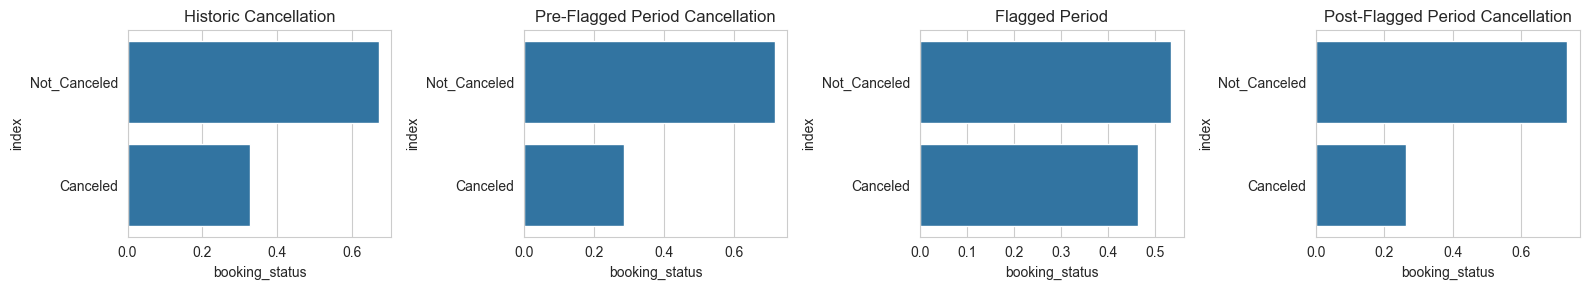

In [16]:
fig, axs = plt.subplots(1, 4, figsize = (16, 3))

tmp = df[target].value_counts(normalize = True).reset_index()
sns.barplot(data=tmp, y = 'index', x = target, ax = axs[0])
axs[0].set_title("Historic Cancellation")

# before start
tmp = df[df['date'] < flagged_period_start][target].value_counts(normalize = True).reset_index()
sns.barplot(data=tmp, y = 'index', x = target, ax = axs[1])
axs[1].set_title("Pre-Flagged Period Cancellation")

# flagged period
sns.barplot(data=flagged_df[target].value_counts(normalize = True).reset_index(), y = 'index', x = target, ax = axs[2])
axs[2].set_title("Flagged Period")

# after flagged period
tmp = df[df['date'] > flagged_period_end][target].value_counts(normalize = True).reset_index()
sns.barplot(data=tmp, y = 'index', x = target, ax = axs[3])
axs[3].set_title("Post-Flagged Period Cancellation")

plt.tight_layout()

## Categorical Variable Analysis

### Historic

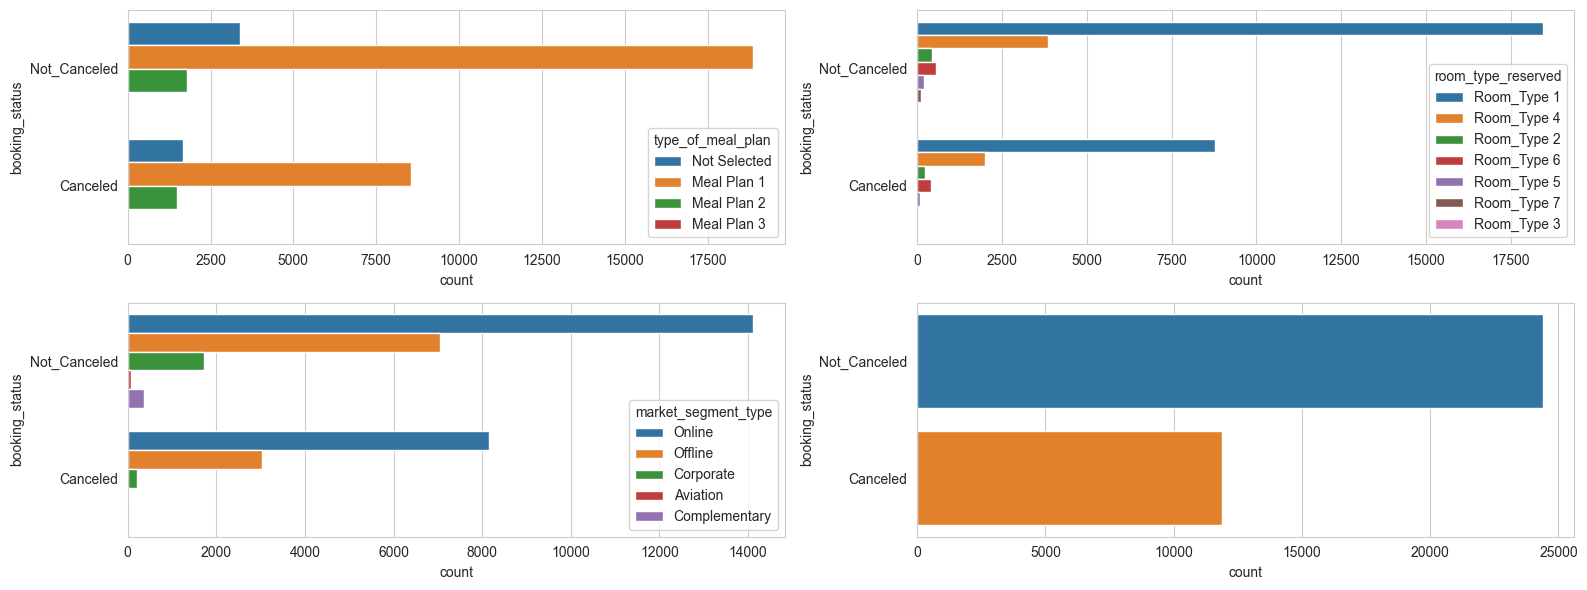

In [17]:
items = df.select_dtypes(include = 'object').columns
n_cols = int(round(len(items) / 2, 0))

fig, axs = plt.subplots(2, n_cols, figsize = (16, 6))
axs = axs.flatten()

i = 0
for col in items:

    sns.countplot(data = df, y = target, hue = col, ax=axs[i])
    i += 1
    
plt.tight_layout()

### Flagged Period

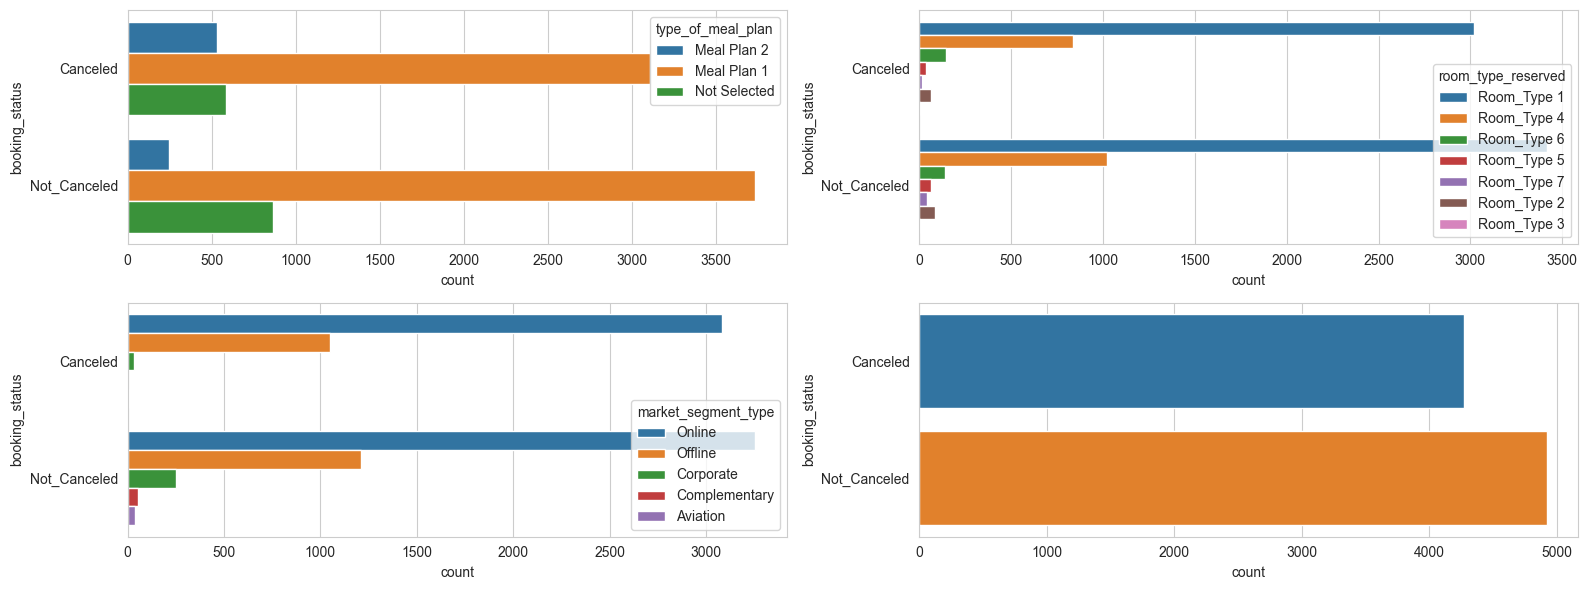

In [18]:
items = df.select_dtypes(include = 'object').columns
n_cols = int(round(len(items) / 2, 0))

fig, axs = plt.subplots(2, n_cols, figsize = (16, 6))
axs = axs.flatten()

i = 0
for col in items:

    sns.countplot(data = flagged_df, y = target, hue = col, ax=axs[i])
    i += 1
    
plt.tight_layout()

## Numeric variable analysis

### Historic 

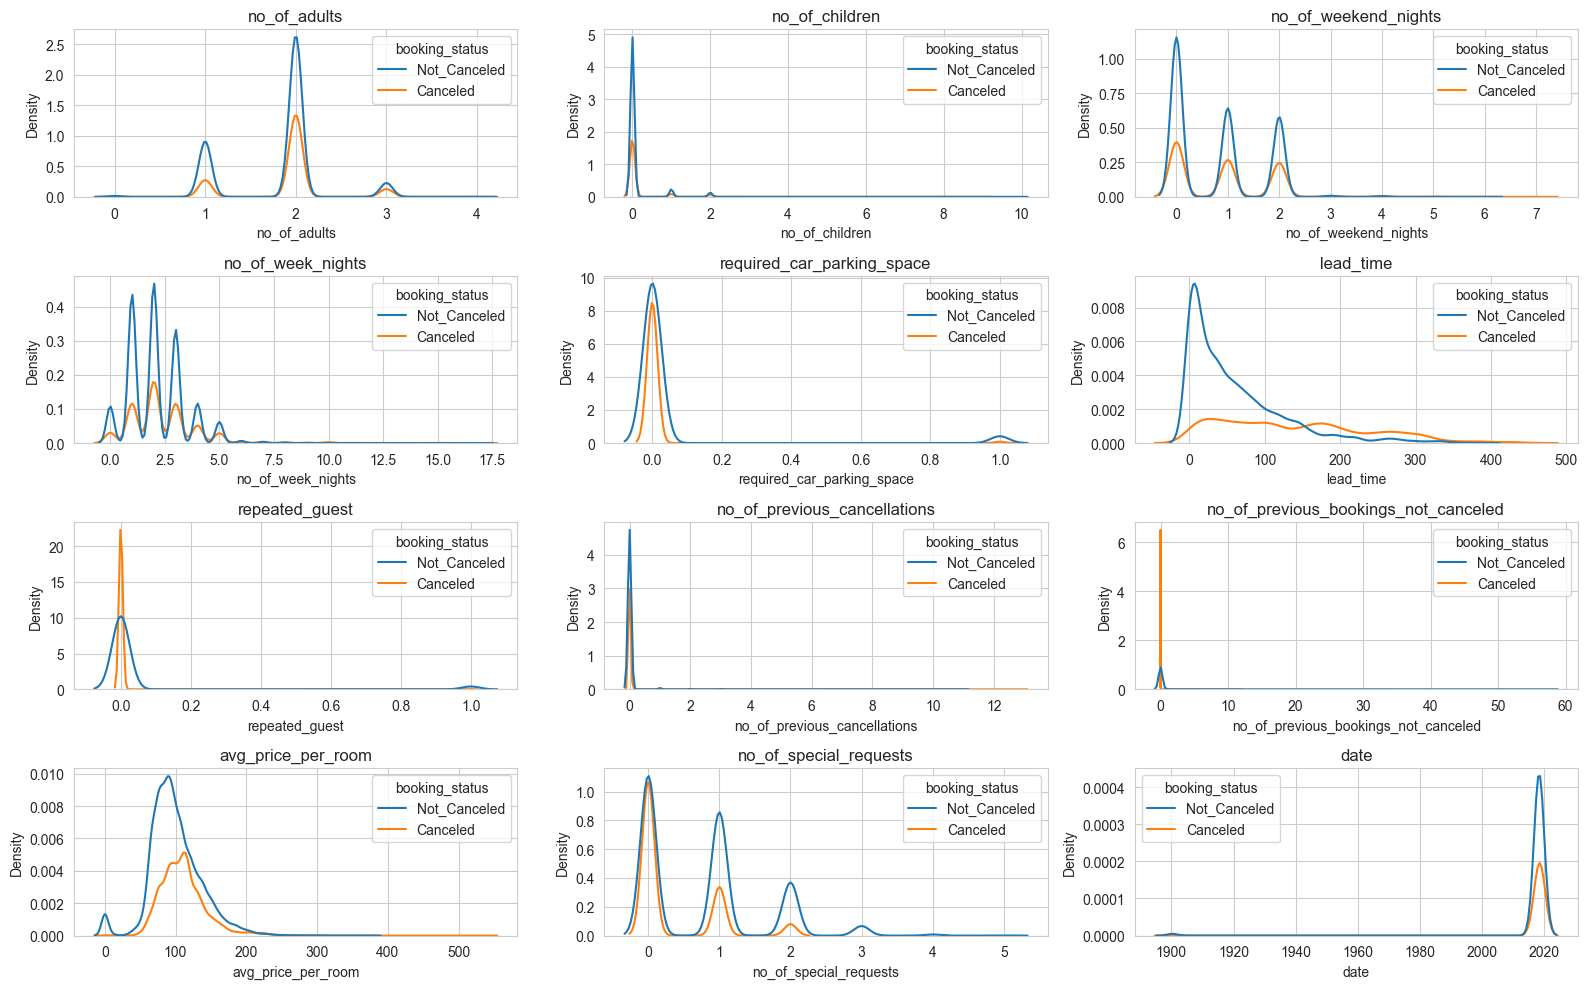

In [19]:
ignore_list = ['arrival_year', 'arrival_month', 'arrival_date']
items = [i for i in df.select_dtypes(exclude = 'object').columns if i not in ignore_list]

n_rows = 4
n_cols = int(round(len(items) / n_rows, 0))

fig, axs = plt.subplots(n_rows, n_cols, figsize = (16, 10))
axs = axs.flatten()

i = 0
for col in items:
    sns.kdeplot(data = df, x = col, hue = target, ax=axs[i], hue_order=['Not_Canceled', 'Canceled'])
    axs[i].set_title(col)
    i += 1

plt.tight_layout()

### Flagged Period

/var/folders/qq/_pxy1w012md00pykw2bn68bw0000gn/T/ipykernel_79043/671093784.py:12: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = flagged_df, x = col, hue = target, ax=axs[i], hue_order=['Not_Canceled', 'Canceled'])


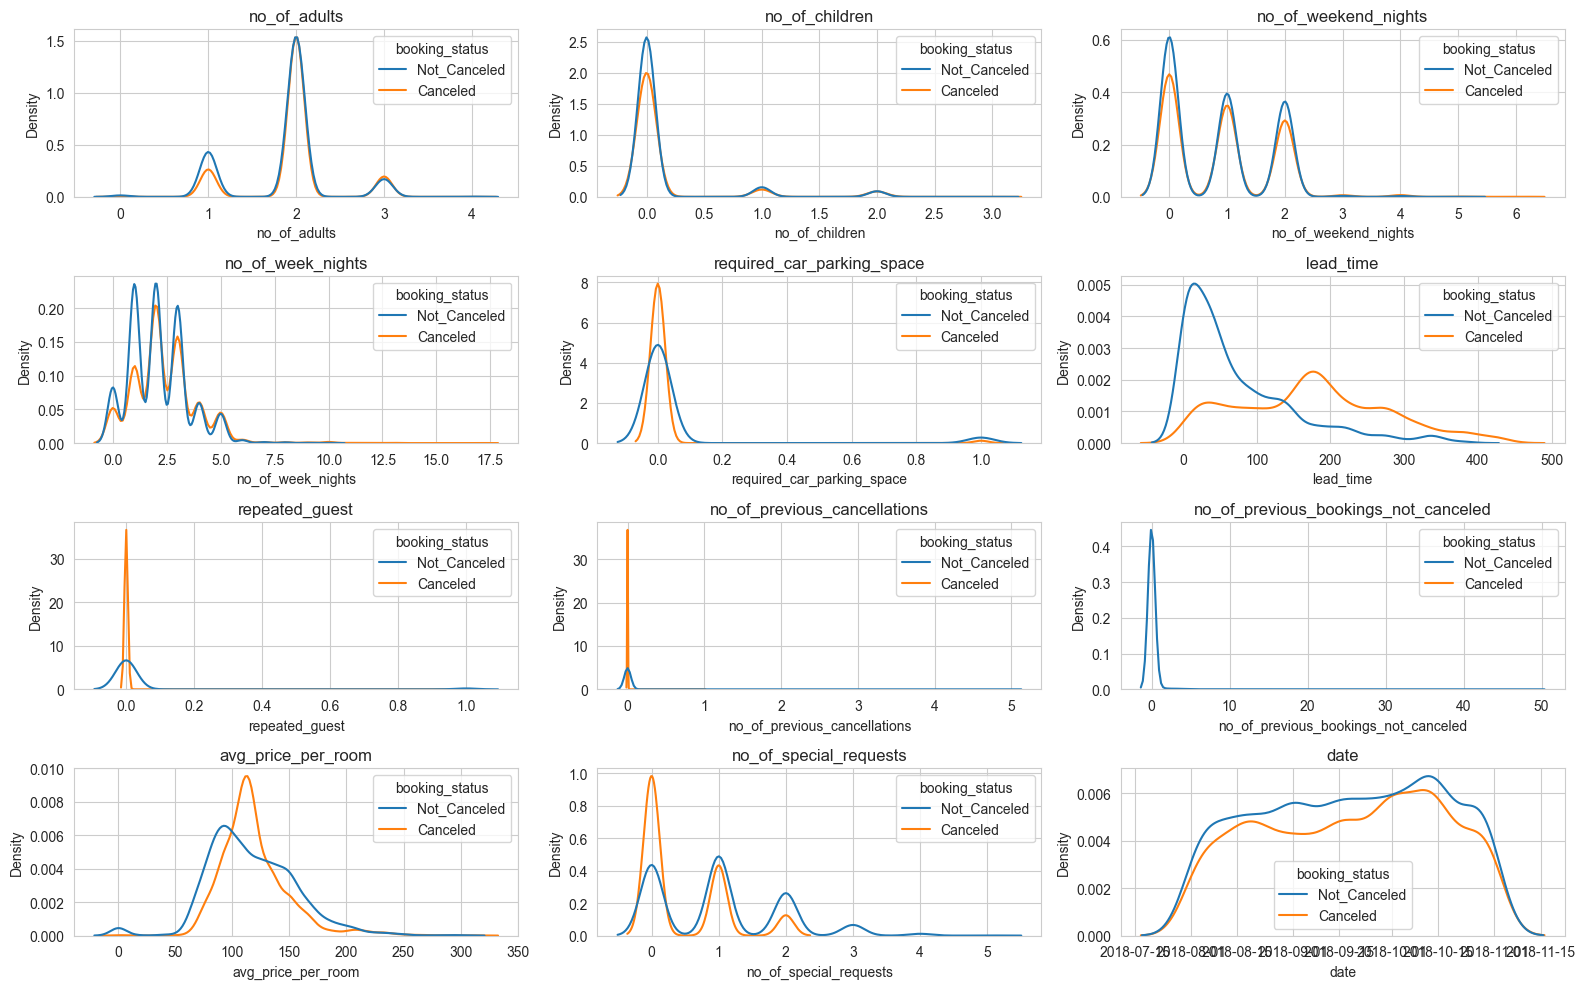

In [20]:
ignore_list = ['arrival_year', 'arrival_month', 'arrival_date']
items = [i for i in df.select_dtypes(exclude = 'object').columns if i not in ignore_list]

n_rows = 4
n_cols = int(round(len(items) / n_rows, 0))

fig, axs = plt.subplots(n_rows, n_cols, figsize = (16, 10))
axs = axs.flatten()

i = 0
for col in items:
    sns.kdeplot(data = flagged_df, x = col, hue = target, ax=axs[i], hue_order=['Not_Canceled', 'Canceled'])
    axs[i].set_title(col)
    i += 1

plt.tight_layout()

### Historic: Filter outliers

/var/folders/qq/_pxy1w012md00pykw2bn68bw0000gn/T/ipykernel_79043/3726000110.py:21: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data = tmp, x = col, hue = target, ax=axs[i], hue_order=['Not_Canceled', 'Canceled'])


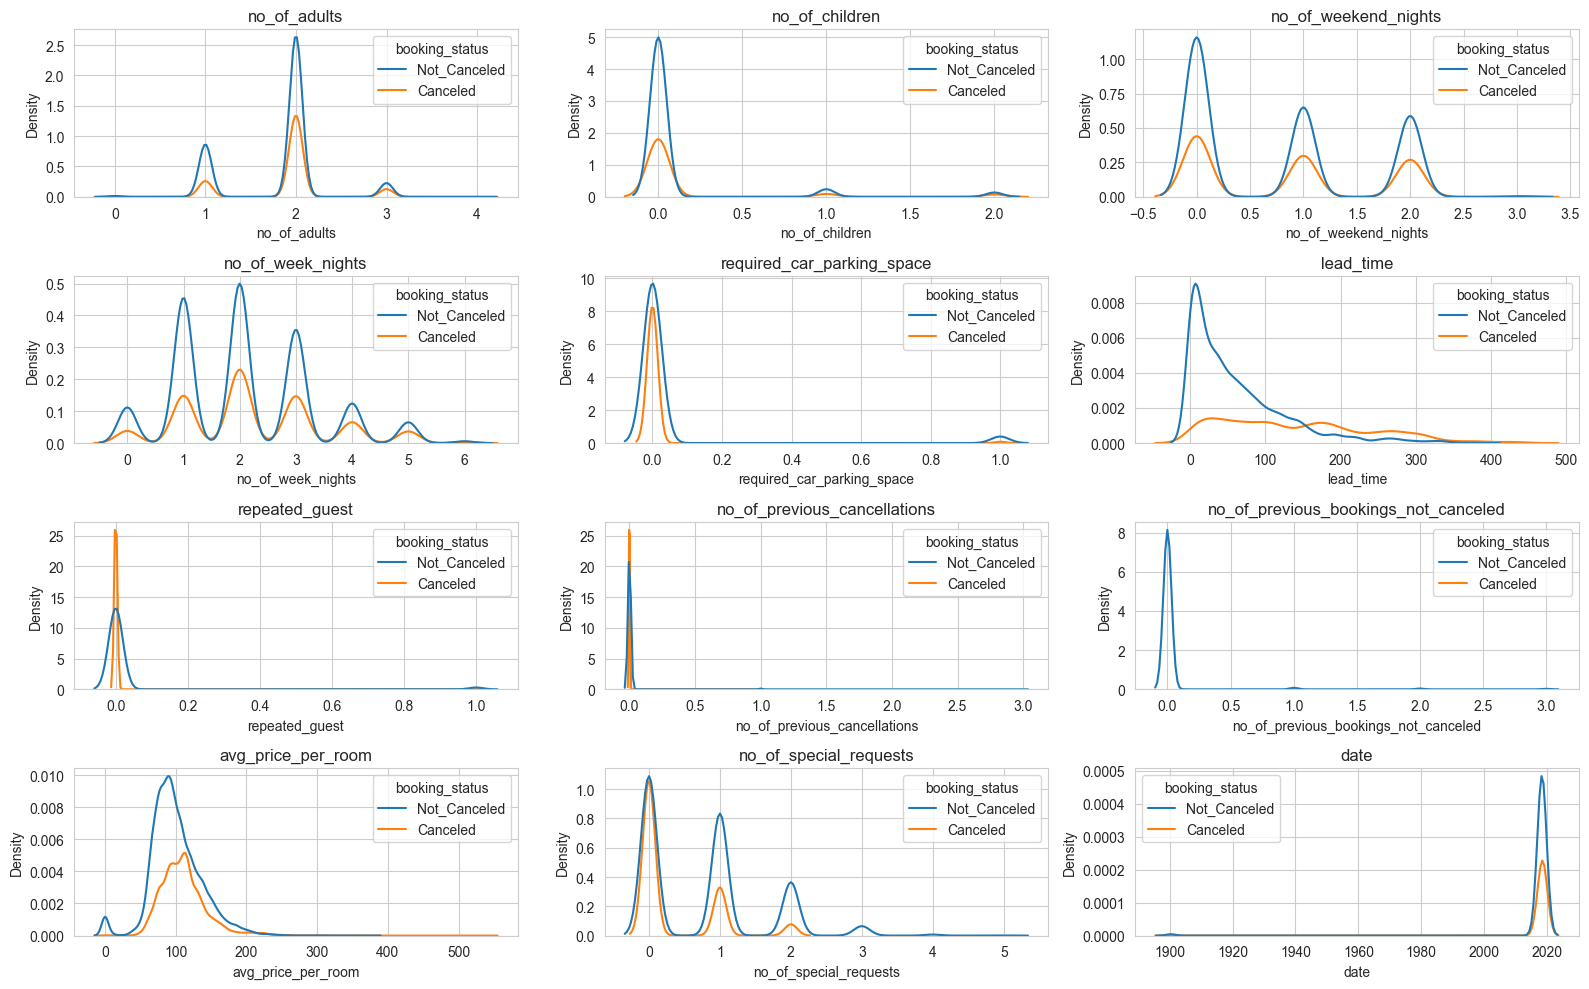

In [21]:
mask1 = df['repeated_guest'] < 3
mask2 = df['no_of_previous_cancellations'] < 4
mask3 = df['no_of_children'] < 3
mask4 = df['no_of_weekend_nights'] < 4
mask5 = df['no_of_week_nights'] < 7
mask6 = df['no_of_previous_bookings_not_canceled'] < 4

tmp = df[mask1 & mask2 & mask3 & mask4 & mask5 & mask6]

ignore_list = ['arrival_year', 'arrival_month', 'arrival_date']
items = [i for i in df.select_dtypes(exclude = 'object').columns if i not in ignore_list]

n_rows = 4
n_cols = int(round(len(items) / n_rows, 0))

fig, axs = plt.subplots(n_rows, n_cols, figsize = (16, 10))
axs = axs.flatten()

i = 0
for col in items:
    sns.kdeplot(data = tmp, x = col, hue = target, ax=axs[i], hue_order=['Not_Canceled', 'Canceled'])
    axs[i].set_title(col)
    i += 1


plt.tight_layout()

### Lead Time: Before, Flagged, and After

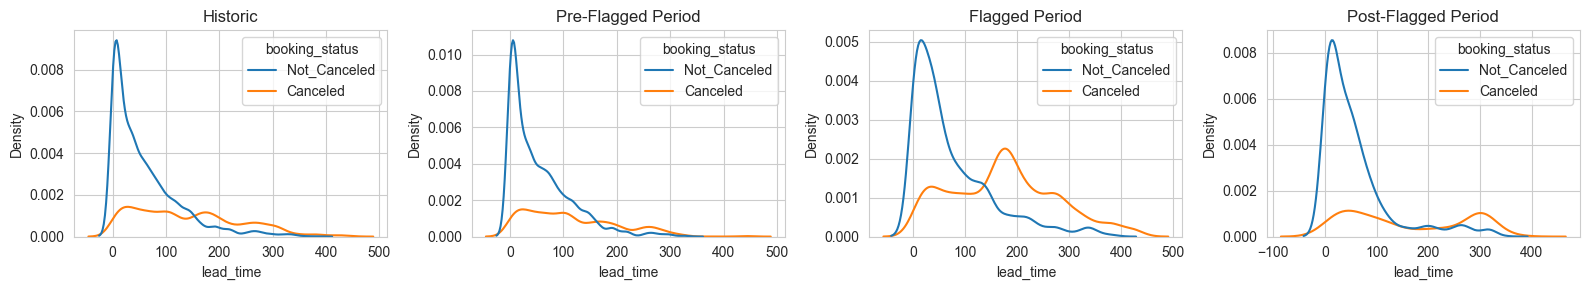

In [22]:
fig, axs = plt.subplots(1, 4, figsize = (16, 3))

sns.kdeplot(data = df, x = 'lead_time', hue = target, ax=axs[0], hue_order = ['Not_Canceled', 'Canceled'])
axs[0].set_title("Historic")

# before start
tmp = df[df['date'] < flagged_period_start]
sns.kdeplot(data = tmp, x = 'lead_time', hue = target, ax=axs[1], hue_order = ['Not_Canceled', 'Canceled'])
axs[1].set_title("Pre-Flagged Period")

# flagged period
sns.kdeplot(data=flagged_df, x = 'lead_time', hue = target, ax = axs[2], hue_order = ['Not_Canceled', 'Canceled'])
axs[2].set_title("Flagged Period")

# after flagged period
tmp = df[df['date'] > flagged_period_end]
sns.kdeplot(data=tmp, x = 'lead_time', hue = target, ax = axs[3], hue_order = ['Not_Canceled', 'Canceled'])
axs[3].set_title("Post-Flagged Period")

plt.tight_layout()

# Model Building

## Remap target variable

In [23]:
target_mapping = {
    'Not_Canceled': 0,
    'Canceled': 1
}

df['booking_status'] = df['booking_status'].map(target_mapping)

## Drop missing

In [24]:
# filter incorrect dates
df = df[df['date'] >= '2017-07-01']
df = df.drop(['arrival_year','arrival_month','arrival_date'], axis = 1)

## Create Flagged Period

In [30]:
# create flagged period
df['flagged_period'] = (df['date'] > flagged_period_start) & (df['date'] < flagged_period_end)
df['flagged_period'] = df['flagged_period'].astype(int)

# drop date column
df = df.drop('date', axis = 1)

## Pipeline

In [31]:
num_features = [
    'no_of_adults', 
    'no_of_children', 
    'no_of_weekend_nights',
    'no_of_week_nights', 
    'required_car_parking_space', 
    'lead_time',
    'repeated_guest', 
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled', 
    'avg_price_per_room',
    'no_of_special_requests',
    'flagged_period'
]

cat_features = list(df.select_dtypes(include = 'object').columns)

In [32]:
num_preproc = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

cat_preproc = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(
        handle_unknown = "ignore", 
        drop = 'first'
    )
)

preproc = make_column_transformer(
    (num_preproc, num_features),
    (cat_preproc, cat_features),
    remainder = 'drop'
)
preproc

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['no_of_adults', 'no_of_children',
                                  'no_of_weekend_nights', 'no_of_week_nights',
                                  'required_car_parking_space', 'lead_time',
                                  'repeated_guest',
                                  'no_of_previous_cancellations',
                                  'no_of_previous_bookings_not_canceled',
                                  'avg_price_per_room',
                                  'no_of_special_requests', 'flagged_period']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['type_of_meal_plan', 'room_type_reserved',
                                  'market_segment_type'])])

## Train-test split

In [33]:
X = df.drop(target, axis = 1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [34]:
# Deploy specific model to pipeline: hyperparameter tuning

param_grid = {
    'randomforestclassifier__n_estimators': [10, 50, 100, 150],
    'randomforestclassifier__max_depth': [5, 10],
    'randomforestclassifier__min_samples_leaf': [5, 10]
}

model = RandomForestClassifier(random_state=42, )
pipe_model = make_pipeline(preproc, model)

grid_search = GridSearchCV(
    pipe_model,
    param_grid,
    cv = 5,
    scoring='precision',
    n_jobs = -1,
    verbose = 1
)

grid_search.fit(X_train, y_train)

rf_best_score = grid_search.best_score_

print(f"Best score: {round(rf_best_score, 2)}")
print(f"Best params: {grid_search.best_params_}")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best score: 0.91
Best params: {'randomforestclassifier__max_depth': 5, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 100}


## Selecting Model

In [35]:
# Selecting tuned model

model = RandomForestClassifier(
    n_estimators = grid_search.best_params_['randomforestclassifier__n_estimators'], 
    max_depth = grid_search.best_params_['randomforestclassifier__max_depth'], 
    min_samples_leaf = grid_search.best_params_['randomforestclassifier__min_samples_leaf']
)

pipe_model = make_pipeline(preproc, model)

pipe_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['no_of_adults',
                                                   'no_of_children',
                                                   'no_of_weekend_nights',
                                                   'no_of_week_nights',
                                                   'required_car_parking_space',
                                                   'lead_time',
                                                   'repeated_guest',
                                                   'no_of_previous_cancellation...
                                                   'no_of_special_requests',
                                                   'flagged_period']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['type_of_meal_plan',
                                                   'room_type_reserved',
                                                   'market_segment_type'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=5, min_samples_leaf=5))])

In [36]:
# Function to extract feature names from ColumnTransformer with consideration for OneHotEncoder
def get_feature_names(column_transformer):
    # This will hold the names of the features modified by transformers
    feature_names = []
    
    # Loop over all transformers in the ColumnTransformer
    for transformer_info in column_transformer.transformers_:
        transformer_name, transformer, original_features = transformer_info
        if transformer_name != 'remainder':
            if hasattr(transformer, 'get_feature_names_out'):
                # If the transformer has `get_feature_names_out`, use it
                names = transformer.get_feature_names_out(original_features)
                feature_names.extend(names)
            else:
                # If not, just append the original feature name
                feature_names.extend(original_features)
        else:
            # If the transformer is the 'remainder', dealing with all other features not listed explicitly
            feature_names.extend(original_features)
    
    return feature_names

In [37]:
# Get feature names
feature_names = get_feature_names(preproc)

# Get feature importances
rf_classifier = pipe_model.named_steps['randomforestclassifier']
importances = rf_classifier.feature_importances_

# Answer to the original question: what factors affect whether customers cancel their booking.

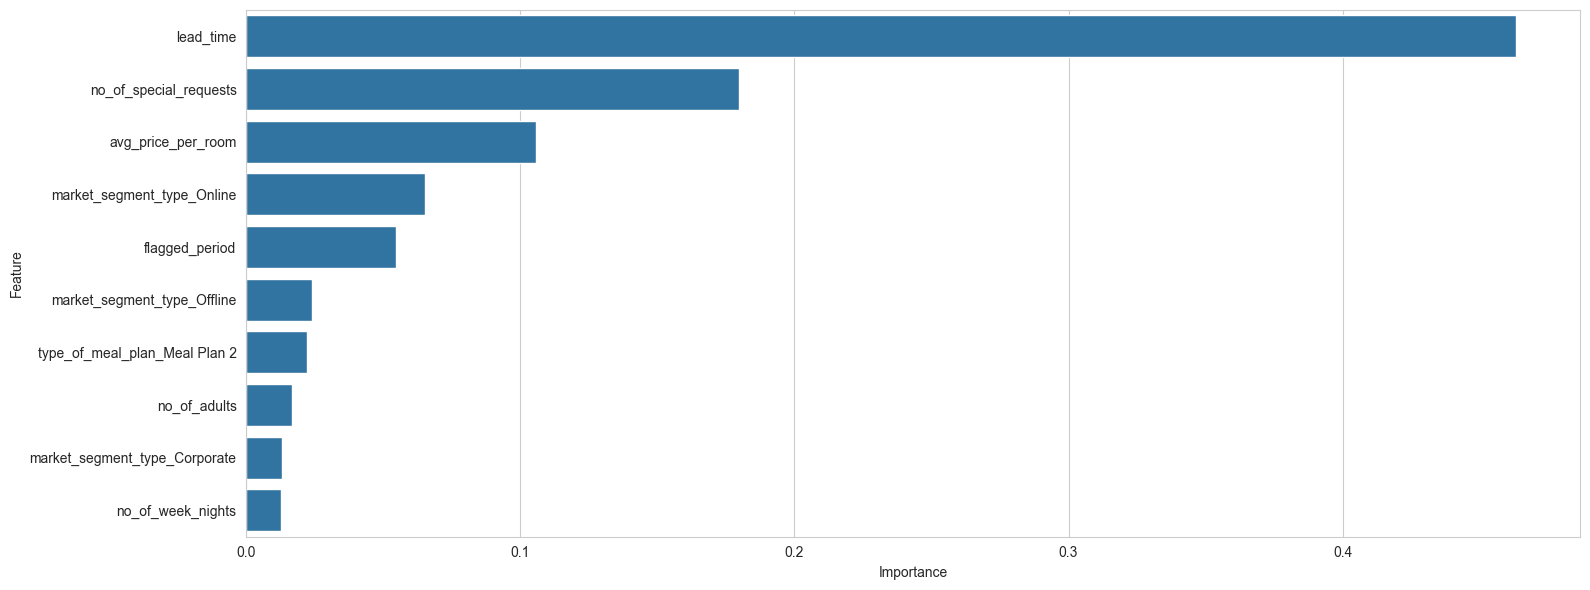

In [38]:
plt.figure(figsize = (16, 6))

feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

features_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False).reset_index()
features_importances_df = features_importances_df.iloc[:10]

sns.barplot(data = features_importances_df, y = 'Feature', x = 'Importance')
plt.tight_layout()

In [39]:
print("The most important features for predicting hotel cancellation are: ")
for i, row in features_importances_df.iterrows():
    print(f"{i+1}) {row['Feature']}, (importance: {round(row['Importance'], 3)})")

    if i == 2:
        break

The most important features for predicting hotel cancellation are: 
1) lead_time, (importance: 0.463)
2) no_of_special_requests, (importance: 0.18)
3) avg_price_per_room, (importance: 0.106)
